### Import Modules 

In [71]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  #lib for cli progress bar
from time import time
from gc import collect

from learning_curves import *  #learning curves and graph functions

#algorithm import
from NaiveBayes import *

#CONSTANTS
_NUM_WORDS = 25

def getDataPerPercentage(X, Y, p): 
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=1-p)
    return (xtrain, ytrain), (xtest, ytest)

### Creating the volcabulary

In [72]:
#Data load
print("Loading data")
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.imdb.load_data(num_words=_NUM_WORDS)

word2index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word2index.items())
index2word[0] = '[pad]'  #padding
index2word[1] = '[bos]'  #begining of sentence
index2word[2] = '[oov]'  #out of vocabulary

xtrain = np.array([' '.join([index2word[idx] for idx in text]) for text in xtrain])
xtest = np.array([' '.join([index2word[idx] for idx in text]) for text in xtest])

#Creates the volcabulary
print("Creating vocabulary")
vocabulary = list()
for text in xtrain:
    tokens = text.split()
    vocabulary.extend(tokens)

vocabulary = list(set(vocabulary))

#preprocess the vocabulary
print("Preprocessing vocabulary")
#removes whitespaces from words
for i in range(len(vocabulary)):
    vocabulary[i] = vocabulary[i].strip()

vocabulary = list(set(vocabulary))

#removes numbers that are strings and words with length <= 1
for word in vocabulary:
    if word.isnumeric() or len(word) <= 1:
        vocabulary.remove(word)

#Neutral words exist in the dataset, eg. 'i', 'it' etc. We use the nltk library which already includes some neutral words, to remove them 
from nltk.corpus import stopwords
for stopword in stopwords.words('english'):
    if stopword in vocabulary:
        for _ in range(vocabulary.count(stopword)):
            vocabulary.remove(stopword)

Loading data
Creating vocabulary
Preprocessing vocabulary


In [73]:
#Creating Binary Vectors
print("Creating Binary Vectors")
xtrain_binary = list()
xtest_binary = list()

for text in tqdm(xtrain):
    tokens = text.split()
    binary_vector = list()
    for vocab_token in vocabulary:
        if vocab_token in tokens:
            binary_vector.append(1)
        else:
            binary_vector.append(0)
    xtrain_binary.append(binary_vector)

xtrain_binary = np.array(xtrain_binary)

for text in tqdm(xtest):
    tokens = text.split()
    binary_vector = list()
    for vocab_token in vocabulary:
        if vocab_token in tokens:
            binary_vector.append(1)
        else:
            binary_vector.append(0)
    xtest_binary.append(binary_vector)

xtest_binary = np.array(xtest_binary)

#Concatenating data in order to split it later
X = np.concatenate((xtrain_binary, xtest_binary))
Y = np.concatenate((ytrain, ytest))


percentages =  [pr/10 for pr in range(1, 10)]
train_algo_accuracy = np.empty(len(percentages))
train_algo_precision = np.empty(len(percentages))
train_algo_recall = np.empty(len(percentages))
train_algo_f_measure = np.empty(len(percentages))

test_algo_accuracy= np.empty(len(percentages))
test_algo_precision = np.empty(len(percentages))
test_algo_recall =np.empty(len(percentages))
test_algo_f_measure = np.empty(len(percentages))

Creating Binary Vectors


100%|██████████| 25000/25000 [00:02<00:00, 10032.88it/s]


## Running the Naive Bayes Algorithm

In [74]:
#Initiate algorithm
algo = NaiveBayesClassification(xtrain_binary, ytrain)

i = 0
print()
for train_size in percentages:
    (xtrain_binary, ytrain), (xtest_binary, ytest) = getDataPerPercentage(X,Y,train_size)


    print("Training with " + str(int(train_size*100)) + "% of the data", end="\r")
    start = time()

    algo.fit() #Naive Bayes training

    train_predictions = algo.predict(xtrain_binary)  #Naive Bayes testing
    test_predictions = algo.predict(xtest_binary)  #Naive Bayes testing

    end = time()
    #print(f"{end-start:.2f})

    train_algo_accuracy[i] = accuracy(train_predictions, ytrain)
    train_algo_precision[i] = precision(train_predictions, ytrain)
    train_algo_recall[i] = recall(train_predictions, ytrain)
    train_algo_f_measure[i] = F_measure(train_predictions, ytrain)

    test_algo_accuracy[i] = accuracy(test_predictions, ytest)
    test_algo_precision[i] = precision(test_predictions, ytest)
    test_algo_recall[i] = recall(test_predictions, ytest)
    test_algo_f_measure[i] = F_measure(test_predictions, ytest)

    i += 1
    del xtrain_binary, ytrain, xtest_binary, ytest
    collect()
    



## Generating the Graphs

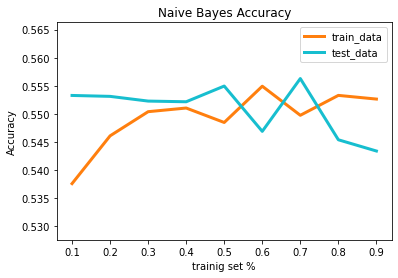

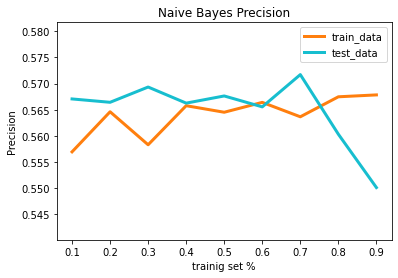

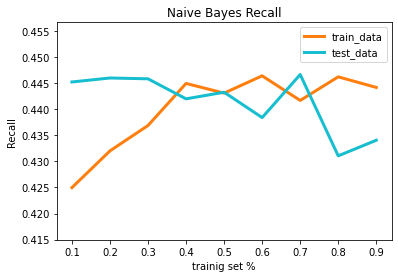

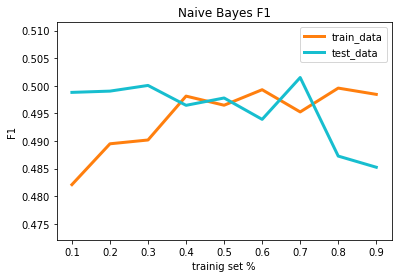

In [75]:
def generateGraph(percentages, train_data, test_data, curve_name, algorithm_name, num_words, save = False):
    _, ax1 = plt.subplots()
    
    plt.title(algorithm_name +" "+ curve_name)

    l1, = ax1.plot(percentages,train_data,'tab:orange', linewidth = 3)
    l2, = ax1.plot(percentages,test_data,'tab:cyan', linewidth = 3)

    plt.legend([l1, l2], ["train_data", "test_data"])
    plt.xlabel("trainig set %")
    plt.ylabel(curve_name)

    l = np.concatenate((train_data,test_data), axis = None)    
    plt.ylim(l.min()-0.01, l.max()+0.01)

    if save == True:
        plt.savefig( "Plots/" + algorithm_name+ "_" + curve_name + "_" + str(num_words) + "_words" + '.png')
    plt.show()


generateGraph(percentages, train_algo_accuracy, test_algo_accuracy, "Accuracy", "Naive Bayes", _NUM_WORDS)
generateGraph(percentages, train_algo_precision, test_algo_precision, "Precision", "Naive Bayes", _NUM_WORDS)
generateGraph(percentages, train_algo_recall, test_algo_recall,"Recall", "Naive Bayes", _NUM_WORDS)
generateGraph(percentages, train_algo_f_measure, test_algo_f_measure, "F1", "Naive Bayes", _NUM_WORDS)